In [7]:
df=pd.read_csv("linkedin_job_posts_skills_short.csv")

In [8]:
import pandas as pd

In [9]:
df.head()

,Unnamed: 0,sn,job_link_cleaned,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,cleaned_skills
0,0,0,3802078767,2024-01-21 07:12:29.00256+00,True,True,False,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite,"Medical equipment sales, Key competitors, Term...","['medical equipment sales', 'key competitors',..."
1,1,1,3803386312,2024-01-21 07:39:58.88137+00,True,True,False,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite,"Nursing, Bachelor of Science in Nursing, Maste...","['nursing', 'bachelor of science in nursing', ..."
2,2,2,3771464419,2024-01-21 07:40:00.251126+00,True,True,False,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite,"Restaurant Operations Management, Inventory Ma...","['restaurant operations management', 'inventor..."
3,3,3,3797661348,2024-01-21 07:40:00.308133+00,True,True,False,Independent Real Estate Agent,Howard Hanna | Rand Realty,"Englewood Cliffs, NJ",2024-01-16,Pinehurst,United States,Real-Estate Clerk,Mid senior,Onsite,"Real Estate, Customer Service, Sales, Negotiat...","['real estate', 'customer service', 'sale', 'n..."
4,4,4,3790954711,2024-01-21 08:08:19.663033+00,True,True,False,Registered Nurse (RN),Trinity Health MI,"Muskegon, MI",2024-01-14,Muskegon,United States,Nurse Practitioner,Mid senior,Onsite,"Nursing, BSN, Medical License, Virtual RN, Nur...","['nursing', 'bsn', 'medical license', 'virtual..."


In [10]:
df.columns

Index(['Unnamed: 0', 'sn', 'job_link_cleaned', 'last_processed_time',
       'got_summary', 'got_ner', 'is_being_worked', 'job_title', 'company',
       'job_location', 'first_seen', 'search_city', 'search_country',
       'search_position', 'job_level', 'job_type', 'job_skills',
       'cleaned_skills'],
      dtype='object')

In [12]:
from collections import Counter

skill_counter = Counter()

for skills in df['skills_parsed']:
    skill_counter.update(skills)

# keep only skills with freq more than  150
min_freq = 150
selected_skills = [s for s, c in skill_counter.items() if c >= min_freq]

len(selected_skills), selected_skills[:20]


(14710,
 ['terminology',
  'technology',
  'trend',
  'challenge',
  'reimbursement',
  'pipeline management',
  'customer relationships',
  'collaboration',
  'negotiation',
  'trust building',
  'sales opportunities',
  'pharmacy',
  'nursing',
  'bachelors degree',
  'travel',
  'drivers license',
  'bachelor of science in nursing',
  'masters degree in nursing',
  'selfmanagement',
  'education'])

In [13]:
selected_set = set(selected_skills)

df['skills_filtered'] = df['skills_parsed'].apply(
    lambda lst: [s for s in lst if s in selected_set]
)

# Remove jobs with no selected skills 
df_jobs = df[df['skills_filtered'].map(len) > 0].reset_index(drop=True)
print("Jobs before:", len(df), "Jobs after:", len(df_jobs))


Jobs before: 1287095 Jobs after: 1281781


In [14]:
df_jobs['skills_text'] = df_jobs['skills_filtered'].apply(lambda x: " ".join(x))

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(vocabulary=selected_skills)  
X = vec.fit_transform(df_jobs['skills_text'])
X.shape


(1281781, 14710)

In [16]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X)   

X_norm = normalize(X_reduced)


In [17]:
X_norm.shape

(1281781, 50)

In [19]:
k = 5

kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
df_jobs['cluster'] = kmeans.fit_predict(X_norm)   

df_jobs[['job_title', 'skills_filtered', 'cluster']].head()


,job_title,skills_filtered,cluster
0,Account Executive - Dispensing (NorCal/Norther...,"[terminology, technology, trend, challenge, re...",1
1,Registered Nurse - RN Care Manager,"[nursing, bachelor of science in nursing, mast...",2
2,RESTAURANT SUPERVISOR - THE FORKLIFT,"[restaurant operations management, inventory m...",1
3,Independent Real Estate Agent,"[real estate, customer service, sale, negotiat...",0
4,Registered Nurse (RN),"[nursing, bsn, medical license, diversity, equ...",2


In [20]:
for c in sorted(df_jobs['cluster'].unique()):
    subset = df_jobs[df_jobs['cluster'] == c]
    skill_list = []

    for row in subset['skills_filtered']:
        skill_list.extend(row)

    top = Counter(skill_list).most_common(15)

    print(f"\n====== Cluster {c} ======")
    for skill, fr in top:
        print(f"{skill}: {fr}")



====== Cluster 0 ======
customer service: 204600
communication: 135163
teamwork: 97320
communication skills: 68657
leadership: 64303
attention to detail: 57280
sale: 54280
high school diploma: 51673
problemsolving: 50757
problem solving: 48720
inventory management: 48553
time management: 46267
training: 39498
merchandising: 34032
cash handling: 30444

====== Cluster 1 ======
communication: 137679
project management: 87536
leadership: 72211
communication skills: 71853
time management: 67662
problem solving: 66608
teamwork: 63820
data analysis: 60065
attention to detail: 55695
microsoft office suite: 51889
customer service: 45810
problemsolving: 45604
interpersonal skills: 42948
analytical skills: 41754
bachelors degree: 39698

====== Cluster 2 ======
patient care: 90592
nursing: 76705
communication: 61120
teamwork: 41870
documentation: 28142
leadership: 27830
critical thinking: 27287
communication skills: 26105
registered nurse: 25702
patient education: 25090
collaboration: 23671
bls: 

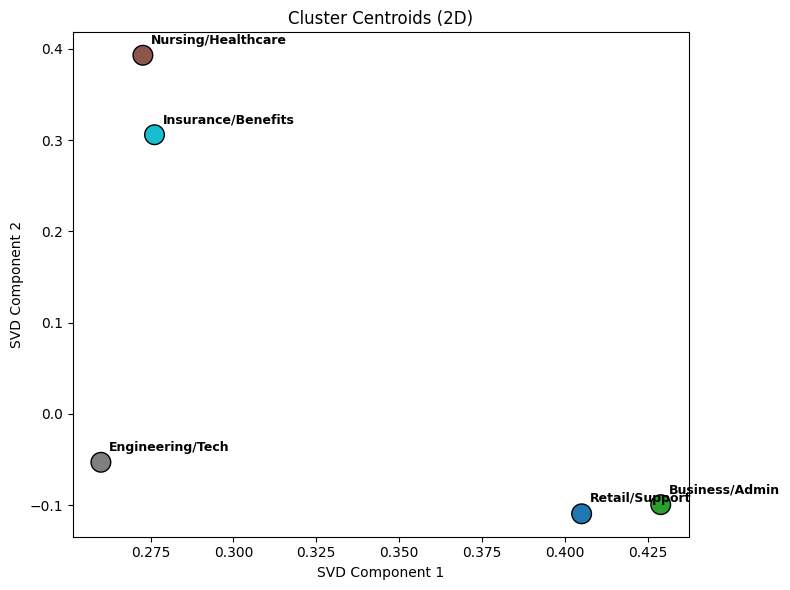

In [25]:

import matplotlib.pyplot as plt
import numpy as np


centroids = kmeans.cluster_centers_


cluster_names_short = {
    0: "Retail/Support",
    1: "Business/Admin",
    2: "Nursing/Healthcare",
    3: "Engineering/Tech",
    4: "Insurance/Benefits"
}

#  first two SVD components (component 0 -> x, component 1 -> y)
xs = centroids[:, 0]
ys = centroids[:, 1]
k = len(xs)

plt.figure(figsize=(8,6))
plt.scatter(xs, ys, s=200, c=range(k), cmap='tab10', edgecolor='k', zorder=3)

# small offset labels (offset in points)
for i, (x, y) in enumerate(zip(xs, ys)):
    name = cluster_names_short.get(i, f"C{i}")
    plt.annotate(name,
                 xy=(x, y),
                 xytext=(6, 6),              # offset the text by 6 points right & up
                 textcoords='offset points',
                 fontsize=9,
                 fontweight='bold',
                 ha='left',
                 va='bottom')

plt.title("Cluster Centroids (2D)")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.grid(False)
plt.tight_layout()
plt.show()
